## Question for the stakeholder?

* What to do with duplicated incidents? Since they are few can we drop them? - yes keep incident with first callconfirmedDT
* How to deal/ understand meaning of empty in units? - answered
* How to check primary key for each dataset is unique? Do you need to combine columns to do so? Specifically for: units, - answered

In [1]:
# reading data
import pandas as pd
# Save file
from pandas import ExcelWriter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Importing tree, Pipeline, GridSearchCV from sklearn
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [4]:
from sklearn.metrics import make_scorer,f1_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

In [5]:
from sklearn.inspection import permutation_importance

In [6]:
import haversine
from math import radians, cos, sin, asin, sqrt

In [7]:
import re

In [8]:
%matplotlib inline

In [9]:
df_facility = pd.read_csv("dataset/Facilities.txt", error_bad_lines=False, delimiter= '|')
print(df_facility.shape)
df_facility.head(2)

(32, 7)


,Facility_Name,Facility_Location_Code,Facility_Type_Of_Facility,Facility_Hospital_Designation_List,Facility_Latitude,Facility_Longitude,Facility_Full_Address
0,Novant Health UVA Haymarket Medical Center,216,Free Standing Emergency Room,Hospital (General),38.423916,77.401647,"15225 Heathcote Blvd, Haymarket, Virginia, 201..."
1,Kaiser Permanente - Tysons Corner - Advanced U...,700,Free Standing Emergency Room,NaN,38.929137,77.224601,"8008 Westpark Drive, McLean, Virginia, 22102, ..."


In [10]:
df_facility.isnull().sum().sort_values()

Facility_Name                         0
Facility_Location_Code                0
Facility_Full_Address                 0
Facility_Type_Of_Facility             2
Facility_Latitude                     3
Facility_Longitude                    3
Facility_Hospital_Designation_List    7
dtype: int64

In [11]:
df_facility.Facility_Latitude.fillna(0, inplace=True)

In [12]:
df_facility.Facility_Longitude.fillna(0, inplace=True)

In [13]:
df_facility.Facility_Name.unique()

array(['Novant Health UVA Haymarket Medical Center',
       'Kaiser Permanente - Tysons Corner - Advanced Urgent Care',
       'Landing Zone / Non-Hospital', 'MWHC Stafford Hospital',
       'Kaiser Permanente - Woodbridge - Advanced Urgent Care',
       'Merrifield Mental Health',
       'Walter Reed National Military Medical Center',
       'Suburban Hospital', 'Landing Zone', 'Inova Mount Vernon Hospital',
       'MedStar Southern Maryland Hospital Center',
       'Inova HealthPlex - Ashburn', "Children's National Medical Center",
       'Sibley Memorial Hospital',
       'Inova Emergency Care Center - Reston/Herndon',
       'George Washington University Hospital',
       'Novant Health UVA Prince William Medical Center',
       'Inova Alexandria Hospital',
       'Inova HealthPlex - Franconia/Springfield',
       'Inova Fairfax Hospital', 'HCA StoneSprings Hospital Center',
       'Inova Healthplex - Lorton',
       ' Sentara Northern Virginia Medical Center',
       'Fort Belvoir

#### Referred hospital description for filling missing values


|  Facility_Name  | Facility_Hospital_Designation_List | Check with partners |
| --- | --- | --- |
| Landing Zone / Non-Hospital	 | non hospital | Confirmed |
|Kaiser Permanente - Tysons Corner - Advanced U...|Hospital General | Confirmed |
|MedStar Southern Maryland Hospital Center | Hospital(General), Burns, Stroke, trauma | Confirmed|
|HCA StoneSprings Hospital Center|Hospital General | Confirmed|
|Out Of Area Hospital Not Listed	 | Hospital General  |Confirmed|

#### Feature - Facility_Hospital_Designation_List

In [14]:


df_facility.loc[ df_facility['Facility_Name'].isin(['Kaiser Permanente - Tysons Corner - Advanced Urgent Care','Kaiser Permanente - Woodbridge - Advanced Urgent Care','HCA StoneSprings Hospital Center', 'Out Of Area Hospital Not Listed']), 'Facility_Hospital_Designation_List'] = 'Hospital(General)'

In [15]:

df_facility.loc[ df_facility['Facility_Name'].isin(['Landing Zone / Non-Hospital','Landing Zone']), 'Facility_Hospital_Designation_List'] = 'Non Hospital'

In [16]:

df_facility.loc[ df_facility['Facility_Name'].isin(['MedStar Southern Maryland Hospital Center']), 'Facility_Hospital_Designation_List'] = 'Hospital(General), Burns, Stroke, trauma'

#### Feature - Facility_Type_Of_Facility

In [17]:
df_facility.Facility_Type_Of_Facility.fillna('Non hospital service', inplace=True)

In [18]:
df_facility.isnull().sum().sort_values()

Facility_Name                         0
Facility_Location_Code                0
Facility_Type_Of_Facility             0
Facility_Hospital_Designation_List    0
Facility_Latitude                     0
Facility_Longitude                    0
Facility_Full_Address                 0
dtype: int64

In [19]:
df_facility['Facility_Name'].unique()

array(['Novant Health UVA Haymarket Medical Center',
       'Kaiser Permanente - Tysons Corner - Advanced Urgent Care',
       'Landing Zone / Non-Hospital', 'MWHC Stafford Hospital',
       'Kaiser Permanente - Woodbridge - Advanced Urgent Care',
       'Merrifield Mental Health',
       'Walter Reed National Military Medical Center',
       'Suburban Hospital', 'Landing Zone', 'Inova Mount Vernon Hospital',
       'MedStar Southern Maryland Hospital Center',
       'Inova HealthPlex - Ashburn', "Children's National Medical Center",
       'Sibley Memorial Hospital',
       'Inova Emergency Care Center - Reston/Herndon',
       'George Washington University Hospital',
       'Novant Health UVA Prince William Medical Center',
       'Inova Alexandria Hospital',
       'Inova HealthPlex - Franconia/Springfield',
       'Inova Fairfax Hospital', 'HCA StoneSprings Hospital Center',
       'Inova Healthplex - Lorton',
       ' Sentara Northern Virginia Medical Center',
       'Fort Belvoir

In [20]:
df_facility['Facility_Location_Code'].unique()

array([216, 700, 107, 116, 701, 106, 386, 385, 999,  47, 363, 364, 327,
       326, 204, 324,  59,   1, 205,  16, 215, 213,  58, 374,   3, 325,
       328,  36, 102,  95, 202,  11], dtype=int64)

## Read the data

In [21]:
# Attributes of incident
incidents = pd.read_excel("IndividualTables.xlsx", sheet_name="incidents")
incidents.shape

(122746, 10)

In [22]:
# Units that responded to an incident
units = pd.read_excel("IndividualTables.xlsx", sheet_name="units")
units.shape

(280156, 7)

In [23]:
# Patient affected in the incident 
patients = pd.read_excel("IndividualTables.xlsx", sheet_name="patients")
patients.shape

(125147, 13)

In [24]:
# 
procedures = pd.read_excel("IndividualTables.xlsx", sheet_name="procedures")
procedures.shape

(121338, 4)

In [25]:
medications = pd.read_excel("IndividualTables.xlsx", sheet_name="medications")
medications.shape

(46916, 4)

In [26]:
units_latlon =  pd.read_excel("IndividualTables.xlsx", sheet_name="latlonunits")

In [27]:
#Merge units with the units_latlon 
print(units.shape, units_latlon.shape)
unitsmerge = units.merge(units_latlon, how="inner", on="UnitStation")
unitsmerge.shape

(280156, 7) (46, 3)


(289634, 9)

In [28]:
unitsmerge["UnitStation"].unique()

array([1, 2, 34, 4, 31, 36, 5, 37, 11, 22, 26, 35, 8, 30, 10, 14, 18, 9,
       24, 28, 12, 39, 13, 29, 41, 32, 27, 23, 15, 21, 40, 17, 25, 38, 16,
       19, 20, 42, 33, 3], dtype=object)

In [29]:
unitsmerge.columns

Index(['PrimaryKey', 'ResponseUnitID', 'UnitPrimaryActionTaken',
       'UnitOtherActionsTaken', 'UnitStation', 'UnitType', 'UnitArrivalOrder',
       'Unit_LAT', 'Unit_LON'],
      dtype='object')

## Understand empty values

In [30]:
def view_empty_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Displays the count and % of empty values in a dataframe.
    """
    res = pd.concat([df.dtypes, df.isnull().sum(), df.isnull().sum() / len(df)], axis=1)
    res.columns = ["Dtype", "Count of missing", "% of missing"]
    return res

In [31]:
view_empty_values(incidents)

,Dtype,Count of missing,% of missing
PrimaryKey,int64,0,0.000000
CallConfirmedDT,datetime64[ns],0,0.000000
ShiftDay,object,0,0.000000
TourOfShift,int64,0,0.000000
IncidentFirstDue,float64,14,0.000114
InitialIncidentType,object,0,0.000000
DispatchedIncidentType,object,0,0.000000
ArrivedIncidentType,object,392,0.003194
FinalIncidentType,object,0,0.000000
FinalIncidentTypeDescription,object,43,0.000350


In [32]:
# there are very few missing values in the data so we can drop these records
incidents.dropna(inplace=True)
incidents.shape

(122298, 10)

In [33]:
# are there duplicated Incidents
incidents.PrimaryKey.nunique() / len(incidents)

0.9999672930056093

In [34]:
incidents[incidents.PrimaryKey.duplicated(keep=False)].sort_values("PrimaryKey")

,PrimaryKey,CallConfirmedDT,ShiftDay,TourOfShift,IncidentFirstDue,InitialIncidentType,DispatchedIncidentType,ArrivedIncidentType,FinalIncidentType,FinalIncidentTypeDescription
5583,9934140833,2018-08-10 22:51:12,C,2,414.0,ACCIF,ACCIF,ACCIF,ACCIF,ACCIDENT W/INJ
5584,9934140833,2018-08-10 22:51:12,C,2,414.0,ALS,ALS,ALS,ALS,ALS EMERGENCY
64506,11194080439,2019-10-06 18:40:09,B,3,408.0,ACCIF,ACCIF,ACCIF,ACCIF,ACCIDENT W/INJ
64507,11194080439,2019-10-06 18:40:09,B,3,408.0,ACCIMF,ACCIMF,ACCIMF,ACCIMF,ACCIDENT W/INJ - MEDIC REQ
67223,11244338761,2019-10-26 02:47:26,C,2,433.0,ASLTWF,ASLTWF,ASLTWF,ASLTWF,ASSAULT W/WEAPON
67224,11244338761,2019-10-26 02:47:26,C,2,433.0,MEDICAL,MEDICAL,MEDICAL,MEDICAL,MEDICAL EMERGENCY
102246,11964264456,2020-07-24 22:15:51,A,2,426.0,ACCIF,ACCIF,ACCIF,ACCIF,ACCIDENT W/INJ
102247,11964264456,2020-07-24 22:15:51,A,2,426.0,ACCITF,ACCITF,ACCITF,ACCIF,ACCIDENT W/INJ


In [35]:
# Dropping these records for now
incidents.drop_duplicates(subset=["PrimaryKey"], keep=False, inplace=True)
incidents.shape

(122290, 10)

In [36]:
view_empty_values(unitsmerge)

,Dtype,Count of missing,% of missing
PrimaryKey,int64,0,0.000000
ResponseUnitID,object,0,0.000000
UnitPrimaryActionTaken,object,38,0.000131
UnitOtherActionsTaken,object,183124,0.632260
UnitStation,object,0,0.000000
UnitType,object,0,0.000000
UnitArrivalOrder,float64,25847,0.089240
Unit_LAT,float64,0,0.000000
Unit_LON,float64,0,0.000000


|Column|Missing Value|%missing|Assumed meaning of missing value|
|----|----|----|----|
|UnitOtherActionsTaken|179609|63%|Combine both 'UnitPrimaryActionTaken' and 'UnitOtherActionTaken' |
|UnitStation|49|0.017%|We can drop these values|
|UnitArrivalOrder|26135|9%|No unit arrived- replace with 0|
|UnitTransportedDT|157474|55%|Unit was not transported?|
|UnitTransportedArrivalDT|158333|55%|Unit was not transported?|



|Column|Missing Value|%missing|Assumend meaning|
|----|----|----|----|
|||||
|||||
|||||
|||||

In [37]:
 # Replaced all the null values of 'UnitArrivalOrder' column with value '0' because No unit arrived
unitsmerge['UnitArrivalOrder'].fillna(0, inplace = True)

In [38]:
# Replaced all the null values of 'UnitOtherActionsTaken' column with 'No other action taken' because the no other action was taken
unitsmerge['UnitOtherActionsTaken'].fillna('No other action taken', inplace = True)

In [39]:
# Replaced all the null values of 'UnitPrimaryActionTaken' column with 'No other action taken' because the no  action was taken
unitsmerge['UnitPrimaryActionTaken'].fillna('No action taken', inplace = True)

In [40]:
# Dropping remaning empty values
print(unitsmerge.shape)
unitsmerge.dropna(inplace=True)
unitsmerge.shape

(289634, 9)


(289634, 9)

In [42]:
view_empty_values(unitsmerge)

,Dtype,Count of missing,% of missing
PrimaryKey,int64,0,0.0
ResponseUnitID,object,0,0.0
UnitPrimaryActionTaken,object,0,0.0
UnitOtherActionsTaken,object,0,0.0
UnitStation,object,0,0.0
UnitType,object,0,0.0
UnitArrivalOrder,float64,0,0.0
Unit_LAT,float64,0,0.0
Unit_LON,float64,0,0.0


In [41]:
view_empty_values(patients)

,Dtype,Count of missing,% of missing
PrimaryKey,int64,0,0.000000
PatientID,int64,0,0.000000
TransportUnitID,object,0,0.000000
UnitTransportedDT,datetime64[ns],871,0.006960
UnitTransportedArrivalDT,datetime64[ns],1390,0.011107
TransportLOC,object,478,0.003820
TransportHospitalCode,float64,481,0.003843
TransportHospitalName,object,481,0.003843
ReasonForChoosingHospital,object,480,0.003835
PatientAge,object,2,0.000016


In [43]:
# Replaced all the null values of 'UnitTransportedDT' column with 00:00:0 because the Unit was not transported
patients['UnitTransportedDT'].fillna('00:00:0', inplace = True)

In [44]:
# Replaced all the null values of 'UnitTransportedArrivalDT' column with 00:00:0 because the Unit was not transported
patients['UnitTransportedArrivalDT'].fillna('00:00:0', inplace = True)

In [45]:
# Replaced all the null values of 'TransportHospitalName' column with 'No Hospital service'
patients['TransportHospitalCode'].fillna('No Hospital service', inplace = True)

In [46]:
## Replaced all the null values of 'TransportHospitalCode' column with 'No Hospital name'
patients['TransportHospitalName'].fillna('No Hospital name', inplace = True)

In [47]:
# Replaced all the null values of 'ReasonForChoosingHospital' column with 'No Hospital service'
patients['ReasonForChoosingHospital'].fillna('No Hospital service', inplace = True)

In [48]:
# Replaced all the null values of 'TransportLOC' column with '0'
patients['TransportLOC'].fillna('0', inplace = True)

In [49]:
view_empty_values(patients)

,Dtype,Count of missing,% of missing
PrimaryKey,int64,0,0.000000
PatientID,int64,0,0.000000
TransportUnitID,object,0,0.000000
UnitTransportedDT,object,0,0.000000
UnitTransportedArrivalDT,object,0,0.000000
TransportLOC,object,0,0.000000
TransportHospitalCode,object,0,0.000000
TransportHospitalName,object,0,0.000000
ReasonForChoosingHospital,object,0,0.000000
PatientAge,object,2,0.000016


In [50]:
# Dropping remaning empty values
print(patients.shape)
patients.dropna(inplace=True)
patients.shape

(125147, 13)


(125143, 13)

In [51]:
view_empty_values(procedures)

,Dtype,Count of missing,% of missing
PatientID,int64,0,0.0
ProcedurePrimaryKey,int64,0,0.0
ProcedurePerformed,object,0,0.0
isALS_LOC,int64,0,0.0


In [52]:
view_empty_values(medications)

,Dtype,Count of missing,% of missing
PatientID,int64,0,0.000000
MedicationPrimaryKey,int64,0,0.000000
MedicationGiven,object,5,0.000107
isALS_LOC,int64,0,0.000000


In [53]:
# Replaced all the null values of 'MedicationGiven' column with 'No medication given'
medications['MedicationGiven'].fillna('No medication given', inplace = True)

In [54]:
# Save cleaned data to file
writer = ExcelWriter("IndividualTablesCleaned.xlsx")
incidents.to_excel(writer, "incidents", index=False)
unitsmerge.to_excel(writer, "units", index=False)
patients.to_excel(writer, "patients", index=False)
procedures.to_excel(writer, "procedures", index=False)
medications.to_excel(writer, "medications", index=False)
writer.save()

In [55]:
sorted(medications.MedicationGiven[medications.MedicationGiven.notnull()].unique())

['Acetylsalicylic Acid (Aspirin, ASA) ',
 'Adenosine (Adenocard)',
 'Albuterol (Ventolin) ',
 'Amiodarone (Cordarone)',
 'Atropine (Atropine Sulfate) ',
 'Calcium Chloride (10%) ',
 'Cyanokit (Hydroxocobalamin)',
 'Dextrose 10 % (D10)',
 'Dextrose 50 % (D50)',
 'Diazepam (Valium)',
 'Diphenhydramine (Benadryl)',
 'Epinephrine 0.1 MG/ML (1:10,000)',
 'Epinephrine 1 MG/ML (1:1,000)',
 'Fentanyl Citrate (Sublimaze) ',
 'Glucagon (Glucagen)',
 'Glucose (Oral)',
 'Ipratropium Bromide(Atrovent)',
 'Ketamine (Ketalar)',
 'Lidocaine (2%) (Xylocaine) ',
 'Magnesium Sulfate (50%) ',
 'Methylprednisolone (Solu-Medrol) ',
 'Midazolam (Versed)',
 'Morphine (Morphine Sulfate) ',
 'Naloxone (Narcan)',
 'Nitroglycerin',
 'No medication given',
 'Norepinephrine (Levophed)',
 'Normal saline',
 'Ondansetron (Zofran)',
 'Oxygen',
 'Sodium Bicarbonate (8.4%) ',
 'Tetracaine',
 'Tranexamic Acid (TXA)']

In [56]:
procedures.ProcedurePerformed.nunique(), medications.MedicationGiven.nunique()

(68, 33)

### Model for week 14- Sprint 5.1 - code starts here

In [57]:
# Read cleaned data
incidents = pd.read_excel("IndividualTablesCleaned.xlsx", sheet_name="incidents")
units = pd.read_excel("IndividualTablesCleaned.xlsx", sheet_name="units")
patients = pd.read_excel("IndividualTablesCleaned.xlsx", sheet_name="patients")
procedures = pd.read_excel("IndividualTablesCleaned.xlsx", sheet_name="procedures")
medications = pd.read_excel("IndividualTablesCleaned.xlsx", sheet_name="medications")

In [58]:
def haversine_distance(lon1, lat1, lon2, lat2):
    """
    Calculate the haversine distance
    Use radius of earth 6371 in km 3956 in miles 
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles
    distance = c * r
    return distance

In [59]:
# distance = haversine_distance(long1,lat1,long2,lat2)
# print('\n Haversine distance between 2 points',lat1,long1,'and ',lat2,long2, 'is',distance,'\n')

In [63]:
#Merge patients with the units - Units 0:many patients
print(patients.shape, units.shape)
patientunitsmerge = patients.merge(units, left_on=["PrimaryKey", "TransportUnitID"],  right_on= ["PrimaryKey", "ResponseUnitID"])
patientunitsmerge.shape

(125143, 13) (289634, 9)


(129313, 21)

In [64]:
print(patientunitsmerge.shape, incidents.shape)
incidentpatientunitsmerge = patientunitsmerge.merge(incidents, how="left", on="PrimaryKey")
incidentpatientunitsmerge.shape

(129313, 21) (122290, 10)


(129313, 30)

In [65]:
incidentpatientunitsmerge.columns

Index(['PrimaryKey', 'PatientID', 'TransportUnitID', 'UnitTransportedDT',
       'UnitTransportedArrivalDT', 'TransportLOC', 'TransportHospitalCode',
       'TransportHospitalName', 'ReasonForChoosingHospital', 'PatientAge',
       'PrimaryImpression', 'SecondaryImpression', 'PatientDisposition',
       'ResponseUnitID', 'UnitPrimaryActionTaken', 'UnitOtherActionsTaken',
       'UnitStation', 'UnitType', 'UnitArrivalOrder', 'Unit_LAT', 'Unit_LON',
       'CallConfirmedDT', 'ShiftDay', 'TourOfShift', 'IncidentFirstDue',
       'InitialIncidentType', 'DispatchedIncidentType', 'ArrivedIncidentType',
       'FinalIncidentType', 'FinalIncidentTypeDescription'],
      dtype='object')

In [66]:
incidentpatientunitsmerge['TransportHospitalName'].unique()

array(['Virginia Hospital Center', 'Fairfax Hospital',
       'Reston Hospital Center', 'Fair Oaks Hospital',
       'Alexandria Hospital', 'Mount Vernon Hospital',
       'Fort Belvoir Community Hospital', 'No Hospital name',
       'Loudoun Hospital Center', 'Stone Spring Hospital',
       'Lorton Healthplex', 'Springfield Health Plex',
       'Inova Emergency Care Center (ECC) - Fairfax',
       'Out Of Area Hospital Not Listed', 'MEDSTAR (202-877-7210)',
       'Landing Zone', 'Sentara Northern Virginia Medical Center',
       'Georgetown University Hospital (202-444-2119)',
       'Inova Emergency Care Center (ECC) - Reston/Herndon',
       "Children's National Medical Center (202-476-4682)",
       'Sibley (202-537-4080)',
       'George Washington University Hospital (202-715-4909)',
       'Prince William Hospital (703-369-8869)', 'Ashburn HealthPlex',
       'Southern Maryland Hospital', 'Sibley Memorial Hospital',
       'Inova HealthPlex Emergency Care Center',
       'Inova

In [67]:
incidentpatientunitsmerge.loc[incidentpatientunitsmerge['TransportHospitalCode'] == 'No Hospital service', 'TransportHospitalCode'] = 111
incidentpatientunitsmerge['TransportHospitalCode'] = incidentpatientunitsmerge['TransportHospitalCode'].astype(int)

In [68]:
print(incidentpatientunitsmerge.shape, df_facility.shape)
incidentpatientunitsfacilitiesmerge = incidentpatientunitsmerge.merge(df_facility, how="left", left_on="TransportHospitalCode" , right_on="Facility_Location_Code")
incidentpatientunitsfacilitiesmerge.shape

(129313, 30) (32, 7)


(129313, 37)

In [69]:
#Drop 'Facility_Location_Code'
incidentpatientunitsfacilitiesmerge = incidentpatientunitsfacilitiesmerge.drop(columns= ['Facility_Location_Code'])

In [70]:
incidentpatientunitsfacilitiesmerge.head(15)

,PrimaryKey,PatientID,TransportUnitID,UnitTransportedDT,UnitTransportedArrivalDT,TransportLOC,TransportHospitalCode,TransportHospitalName,ReasonForChoosingHospital,PatientAge,...,DispatchedIncidentType,ArrivedIncidentType,FinalIncidentType,FinalIncidentTypeDescription,Facility_Name,Facility_Type_Of_Facility,Facility_Hospital_Designation_List,Facility_Latitude,Facility_Longitude,Facility_Full_Address
0,9804015371,640838,M401,2018-07-01 02:47:55,2018-07-01 03:06:39,Level 3: 1 Provider (ALS Care),3,Virginia Hospital Center,"Patient's Choice,Closest Facility",80 - 89,...,ALS,ALS,ALS,ALS EMERGENCY,Virginia Hospital Center,Hospital,"Designated Stroke Center,Hospital (General),Pe...",38.889271,77.126523,"1701 N. George Mason Drive, Arlington, Virgin..."
1,9804016046,641032,M401,2018-07-01 11:44:54,2018-07-01 11:55:05,Level 4: 1 Provider (BLS Care),3,Virginia Hospital Center,Patient's Choice,80 - 89,...,BLS,BLS,BLS,BLS EMERGENCY,Virginia Hospital Center,Hospital,"Designated Stroke Center,Hospital (General),Pe...",38.889271,77.126523,"1701 N. George Mason Drive, Arlington, Virgin..."
2,9804018610,641839,M401,2018-07-02 09:54:49,2018-07-02 10:08:54,Level 4: 1 Provider (BLS Care),16,Fairfax Hospital,Closest Facility,40 - 49,...,BLS,BLS,BLS,BLS EMERGENCY,Inova Fairfax Hospital,Hospital,"Designated Stroke Center,Hospital (General),Le...",38.857392,77.226309,"3300 Gallows Road, West Falls Church, Virginia..."
3,9804018946,641959,M401,2018-07-02 11:41:42,2018-07-02 12:08:36,Level 4: 1 Provider (BLS Care),3,Virginia Hospital Center,"Closest Facility,Family Choice,Patient's Physi...",80 - 89,...,BLS,BLS,BLS,BLS EMERGENCY,Virginia Hospital Center,Hospital,"Designated Stroke Center,Hospital (General),Pe...",38.889271,77.126523,"1701 N. George Mason Drive, Arlington, Virgin..."
4,9804019337,642086,M401,2018-07-02 14:21:28,2018-07-02 14:33:41,Level 3: 1 Provider (ALS Care),3,Virginia Hospital Center,"Closest Facility,Patient's Physician's Choice",20 - 29,...,ALS,ALS,ALS,ALS EMERGENCY,Virginia Hospital Center,Hospital,"Designated Stroke Center,Hospital (General),Pe...",38.889271,77.126523,"1701 N. George Mason Drive, Arlington, Virgin..."
5,9804019821,642222,M401,2018-07-02 16:52:04,2018-07-02 17:09:24,Level 3: 1 Provider (ALS Care),3,Virginia Hospital Center,"Closest Facility,Patient's Choice",90 - 99,...,BLS,ALS,ALS,ALS EMERGENCY,Virginia Hospital Center,Hospital,"Designated Stroke Center,Hospital (General),Pe...",38.889271,77.126523,"1701 N. George Mason Drive, Arlington, Virgin..."
6,9804025846,640977,M402,2018-07-01 09:28:07,2018-07-01 09:41:45,Level 3: 1 Provider (ALS Care),16,Fairfax Hospital,Closest Facility,50 - 59,...,BLS,BLS,BLS,BLS EMERGENCY,Inova Fairfax Hospital,Hospital,"Designated Stroke Center,Hospital (General),Le...",38.857392,77.226309,"3300 Gallows Road, West Falls Church, Virginia..."
7,9804026735,641291,M402,2018-07-01 17:54:06,2018-07-01 18:09:54,Level 3: 1 Provider (ALS Care),16,Fairfax Hospital,Closest Facility,80 - 89,...,BLS,BLS,BLS,BLS EMERGENCY,Inova Fairfax Hospital,Hospital,"Designated Stroke Center,Hospital (General),Le...",38.857392,77.226309,"3300 Gallows Road, West Falls Church, Virginia..."
8,9804028602,641809,M402,2018-07-02 09:46:14,2018-07-02 09:58:18,Level 3: 1 Provider (ALS Care),16,Fairfax Hospital,Family Choice,1 - 9,...,ALS,ALS,ALS,ALS EMERGENCY,Inova Fairfax Hospital,Hospital,"Designated Stroke Center,Hospital (General),Le...",38.857392,77.226309,"3300 Gallows Road, West Falls Church, Virginia..."
9,9804029208,642020,M434,2018-07-02 13:24:59,2018-07-02 13:43:00,Level 3: 1 Provider (ALS Care),16,Fairfax Hospital,Closest Facility,70 - 79,...,BLS,BLS,BLS,BLS EMERGENCY,Inova Fairfax Hospital,Hospital,"Designated Stroke Center,Hospital (General),Le...",38.857392,77.226309,"3300 Gallows Road, West Falls Church, Virginia..."


In [71]:
incidentpatientunitsfacilitiesmerge["TransportHospitalName"].nunique()

43

In [72]:
# Categorical data types
incidentpatientunitsfacilitiesmerge.select_dtypes(exclude=['int64','int','int32','float','datetime64[ns]']).columns

Index(['TransportUnitID', 'UnitTransportedDT', 'UnitTransportedArrivalDT',
       'TransportLOC', 'TransportHospitalName', 'ReasonForChoosingHospital',
       'PatientAge', 'PrimaryImpression', 'SecondaryImpression',
       'PatientDisposition', 'ResponseUnitID', 'UnitPrimaryActionTaken',
       'UnitOtherActionsTaken', 'UnitType', 'ShiftDay', 'InitialIncidentType',
       'DispatchedIncidentType', 'ArrivedIncidentType', 'FinalIncidentType',
       'FinalIncidentTypeDescription', 'Facility_Name',
       'Facility_Type_Of_Facility', 'Facility_Hospital_Designation_List',
       'Facility_Full_Address'],
      dtype='object')

In [75]:
# 
incidentpatientunitsfacilitiesmerge.TransportLOC.unique()

array(['Level 3: 1 Provider (ALS Care)', 'Level 4: 1 Provider (BLS Care)',
       'Level 1: 3 or More Providers (ALS Care)',
       'Level 2: 2 Providers (ALS Care)', '0'], dtype=object)

In [76]:
incidentpatientunitsfacilitiesmerge["UnitStation"].unique()

array([ 1,  2, 34,  4, 36,  5, 37, 26,  8, 30, 10,  9, 24, 28, 11, 12, 39,
       13, 41, 32, 14, 27, 23, 15, 21, 17, 16, 38, 18, 19, 20, 22, 40, 35,
       25, 29, 42, 31], dtype=int64)

In [77]:
# TourOfShift: is categorical so converting it to string
incidentpatientunitsfacilitiesmerge["TourOfShift"] = incidentpatientunitsfacilitiesmerge.TourOfShift.astype(str)

In [78]:
# IncidentFirstDue is within or outside fairfax so converting it to dummy
incidentpatientunitsfacilitiesmerge.IncidentFirstDue.fillna(0, inplace=True)
# df.loc[df['First season'] > 1990, 'First Season'] = 1
incidentpatientunitsfacilitiesmerge.loc[incidentpatientunitsfacilitiesmerge.IncidentFirstDue != 0, "IncidentFirstDue"] =1

In [79]:
incidentpatientunitsfacilitiesmerge.dropna(inplace=True)
incidentpatientunitsfacilitiesmerge.shape

(127624, 36)

In [80]:
incidentpatientunitsfacilitiesmerge.columns

Index(['PrimaryKey', 'PatientID', 'TransportUnitID', 'UnitTransportedDT',
       'UnitTransportedArrivalDT', 'TransportLOC', 'TransportHospitalCode',
       'TransportHospitalName', 'ReasonForChoosingHospital', 'PatientAge',
       'PrimaryImpression', 'SecondaryImpression', 'PatientDisposition',
       'ResponseUnitID', 'UnitPrimaryActionTaken', 'UnitOtherActionsTaken',
       'UnitStation', 'UnitType', 'UnitArrivalOrder', 'Unit_LAT', 'Unit_LON',
       'CallConfirmedDT', 'ShiftDay', 'TourOfShift', 'IncidentFirstDue',
       'InitialIncidentType', 'DispatchedIncidentType', 'ArrivedIncidentType',
       'FinalIncidentType', 'FinalIncidentTypeDescription', 'Facility_Name',
       'Facility_Type_Of_Facility', 'Facility_Hospital_Designation_List',
       'Facility_Latitude', 'Facility_Longitude', 'Facility_Full_Address'],
      dtype='object')

In [81]:
# haversine distance between facility and the unitstation
incidentpatientunitsfacilitiesmerge['DistanceUnitToFacility'] = incidentpatientunitsfacilitiesmerge.apply(lambda x: haversine_distance(x['Unit_LON'],x['Unit_LAT'],x['Facility_Longitude'],x['Facility_Latitude']), axis=1)

In [76]:
# incidentpatientunitsfacilitiesmerge.to_excel("dataset/withdistance.xlsx", index=False)

In [82]:
# InitialIncidentType	DispatchedIncidentType	ArrivedIncidentType	FinalIncidentType	FinalIncidentTypeDescription
# Highly corelated features - keeping only one makes sense
incidentpatientunitsfacilitiesmerge = incidentpatientunitsfacilitiesmerge.drop(columns= ["Unit_LAT", "Unit_LON","Facility_Latitude","Facility_Longitude","InitialIncidentType","DispatchedIncidentType","ArrivedIncidentType","FinalIncidentTypeDescription" ])

In [83]:
# Nominal values with large variance, like dates
incidentpatientunitsfacilitiesmerge = incidentpatientunitsfacilitiesmerge.drop(columns= ['UnitTransportedDT', 'UnitTransportedArrivalDT','UnitOtherActionsTaken','SecondaryImpression'])

In [84]:
# Its correlated to 'TransportUnitID_y'
incidentpatientunitsfacilitiesmerge = incidentpatientunitsfacilitiesmerge.drop(columns= ['ResponseUnitID'])

In [85]:
# Highly corelated with the TransportHospitalName
incidentpatientunitsfacilitiesmerge = incidentpatientunitsfacilitiesmerge.drop(columns= ['TransportHospitalCode'])

In [87]:
incidentpatientunitsfacilitiesmerge = incidentpatientunitsfacilitiesmerge.drop(columns= ['PrimaryKey', 'CallConfirmedDT'])
# , 'CallConfirmedDT_x', 'CallConfirmedDT_y'

In [88]:
incidentpatientunitsfacilitiesmerge.FinalIncidentType.unique()

array(['ALS', 'BLS', 'ODF', 'ACCITF', 'SHOTF', 'ACCIF', 'CPRF', 'ACCIMF',
       'ACCIHF', 'AMED', 'STABF', 'SUIAF', 'FBLDG', 'CAVEIN', 'FACCIF',
       'PSERVF', 'FOUT', 'FTH', 'GFRESCUE', 'DROWNF', 'FHIRIS', 'RTRAP',
       'ACCIBF', 'FGAPT', 'RSWIFT', 'GASIN', 'FVEHF', 'CODE1', 'ELEV',
       'RWATER', 'INVF', 'SIG1F', 'FDACCITF', 'ASLTWF', 'FHOU', 'RESCUE',
       'ALRMFD', 'FDACCIF', 'EMETROF', 'STILALRM', 'ECOD', 'HAZMAT',
       'FDACCF', 'MEDICAL', 'FTRKF', 'FDACCIMF', 'RIVERF', 'LOCKF'],
      dtype=object)

In [89]:
# 
incidentpatientunitsfacilitiesmerge.ShiftDay.unique()

array(['B', 'A', 'C'], dtype=object)

In [90]:
# mapping 'PRV' to 111, Drop TA only few values
incidentpatientunitsfacilitiesmerge.UnitStation.unique()

array([ 1,  2, 34,  4, 36,  5, 37, 26,  8, 30, 10,  9, 24, 28, 11, 12, 39,
       13, 41, 32, 14, 27, 23, 15, 21, 17, 16, 38, 18, 19, 20, 22, 40, 35,
       25, 29, 42, 31], dtype=int64)

In [91]:
# Replace 'PRV' with 111
# incidentpatientunitsfacilitiesmerge = incidentpatientunitsfacilitiesmerge.assign(UnitStation= incidentpatientunitsfacilitiesmerge['UnitStation'].replace('PRV',111))

In [92]:
# Drop TA, UnitStation as very few records
# incidentpatientunitsfacilitiesmerge.drop(index=incidentpatientunitsfacilitiesmerge[incidentpatientunitsfacilitiesmerge['UnitStation'] == 'TA'].index, inplace=True)

In [93]:
# incidentpatientunitsfacilitiesmerge['UnitStation'] = incidentpatientunitsfacilitiesmerge['UnitStation'].astype(object).astype(int)

In [94]:
# 
incidentpatientunitsfacilitiesmerge.UnitType.unique()

array(['Medic', 'Ambulance', 'Engine', 'EMS Supervisor', 'Truck'],
      dtype=object)

In [96]:
# 
incidentpatientunitsmerge.TransportLOC.unique()

array(['Level 3: 1 Provider (ALS Care)', 'Level 4: 1 Provider (BLS Care)',
       'Level 1: 3 or More Providers (ALS Care)',
       'Level 2: 2 Providers (ALS Care)', '0'], dtype=object)

In [97]:
incidentpatientunitsmerge.TransportUnitID.unique()

array(['M401', 'M402', 'M434', 'M404', 'M436', 'M405', 'M437', 'M426',
       'M408', 'M408B', 'M430', 'M410B', 'M409B', 'M409', 'M424', 'M410',
       'M428', 'A410E', 'M411B', 'M411', 'M412', 'M439', 'M413', 'M441',
       'M432', 'M414', 'M427', 'M423', 'E415', 'M415', 'M421', 'M417',
       'M416', 'M438', 'M418', 'M419', 'M420', 'M422', 'M440', 'M435',
       'M425', 'M429', 'M442', 'M431', 'A414E', 'M401E', 'E401', 'M412E',
       'A422E', 'A402E', 'M422B', 'EMS403', 'R418', 'A421E', 'E411',
       'E439', 'A414', 'E418', 'A413E', 'E442', 'M405E', 'A402', 'TL430',
       'E440', 'A438E', 'R411', 'TL436', 'M417E', 'A405E', 'E430', 'E423',
       'TL440', 'E409', 'E402B', 'TL401', 'A417E', 'M414E', 'E428',
       'R439', 'A401E', 'A417', 'HM440', 'R401', 'E405', 'A437E', 'A422',
       'TL405', 'E417', 'M422E', 'R421', 'E402', 'E413', 'A410', 'E404',
       'E421', 'E410', 'A401', 'A408E', 'M402B', 'A412E', 'E436', 'E432',
       'T429', 'T411', 'E434', 'E437', 'E438', 'TT430', 'E4

In [98]:
# keep only numbers in TransportUnitID
incidentpatientunitsfacilitiesmerge['TransportUnitID']  = incidentpatientunitsfacilitiesmerge['TransportUnitID'] .apply(lambda row: re.sub("[^0-9]", "", row))

In [99]:
incidentpatientunitsfacilitiesmerge.TransportUnitID.unique()

array(['401', '402', '434', '404', '436', '405', '437', '426', '408',
       '430', '410', '409', '424', '428', '411', '412', '439', '413',
       '441', '432', '414', '427', '423', '415', '421', '417', '416',
       '438', '418', '419', '420', '422', '440', '435', '425', '429',
       '442', '431'], dtype=object)

In [100]:
# incidentpatientunitsfacilitiesmerge['TransportHospitalCode'].unique()

In [101]:
# incidentpatientunitsfacilitiesmerge.loc[incidentpatientunitsfacilitiesmerge['TransportHospitalCode'] == 'No Hospital service', 'TransportHospitalCode'] = 111
# incidentpatientunitsfacilitiesmerge['TransportHospitalCode'] = incidentpatientunitsfacilitiesmerge['TransportHospitalCode'].astype(int)

In [102]:
# explore PrimaryImpression
# t = incidentpatientunitsfacilitiesmerge.PrimaryImpression.apply(lambda s: s.split("-")[0].strip())
# incidentpatientunitsfacilitiesmerge.PrimaryImpression[t == "Neuro"].value_counts()
# incidentpatientunitsfacilitiesmerge.PrimaryImpression.apply(lambda s: s.split("-")[0]).value_counts()

In [103]:
incidentpatientunitsfacilitiesmerge.UnitType.value_counts()

Medic             125872
Ambulance           1736
Engine                13
EMS Supervisor         2
Truck                  1
Name: UnitType, dtype: int64

In [104]:
# dropping features
# incidentpatientunitsfacilitiesmerge = incidentpatientunitsfacilitiesmerge.drop(columns= ['UnitPrimaryActionTaken','UnitType','PrimaryImpression'])

In [105]:
# dropping features - correlated to response
incidentpatientunitsfacilitiesmerge = incidentpatientunitsfacilitiesmerge.drop(columns= ['Facility_Name','Facility_Full_Address', 'Facility_Type_Of_Facility', "Facility_Hospital_Designation_List"])

In [106]:
# Drop ID 
incidentpatientunitsfacilitiesmerge.drop(columns= ["PatientID"], inplace=True)

In [107]:
incidentpatientunitsfacilitiesmerge.select_dtypes(exclude=['int64','int','int32','float','datetime64[ns]']).columns

Index(['TransportUnitID', 'TransportLOC', 'TransportHospitalName',
       'ReasonForChoosingHospital', 'PatientAge', 'PrimaryImpression',
       'PatientDisposition', 'UnitPrimaryActionTaken', 'UnitType', 'ShiftDay',
       'TourOfShift', 'FinalIncidentType'],
      dtype='object')

In [110]:
# Categorical data types
Feature_list = ['TransportUnitID', 'TransportLOC', 
       'ReasonForChoosingHospital', 'PatientAge', 'PrimaryImpression',
       'PatientDisposition', 'UnitPrimaryActionTaken', 'UnitType', 'ShiftDay',
       'TourOfShift', 'FinalIncidentType']


In [111]:
subset_dataframe_featurelist=[]
for variable in Feature_list:
    subset_dataframe_featurelist.append(pd.get_dummies(incidentpatientunitsfacilitiesmerge[variable],prefix=variable, dummy_na=False))

In [112]:
merged_subset_dataframe_featurelist = pd.concat(subset_dataframe_featurelist, axis=1)
merged_subset_dataframe_featurelist.shape

(127624, 609)

In [113]:
%%time
incidentpatientunitsmerged = pd.concat([merged_subset_dataframe_featurelist, incidentpatientunitsfacilitiesmerge], axis=1)
incidentpatientunitsmerged.shape

Wall time: 110 ms


(127624, 625)

In [114]:
# Drop nominal features already converted in numerical features using get_dummies
incidentpatientunitsmerged.drop(Feature_list, axis=1, inplace=True)
incidentpatientunitsmerged.shape

(127624, 614)

In [115]:
incidentpatientunitsmerged.head(5)

,TransportUnitID_401,TransportUnitID_402,TransportUnitID_404,TransportUnitID_405,TransportUnitID_408,TransportUnitID_409,TransportUnitID_410,TransportUnitID_411,TransportUnitID_412,TransportUnitID_413,...,FinalIncidentType_SHOTF,FinalIncidentType_SIG1F,FinalIncidentType_STABF,FinalIncidentType_STILALRM,FinalIncidentType_SUIAF,TransportHospitalName,UnitStation,UnitArrivalOrder,IncidentFirstDue,DistanceUnitToFacility
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Virginia Hospital Center,1,1,1.0,4.013841
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Virginia Hospital Center,1,1,1.0,4.013841
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Fairfax Hospital,1,2,1.0,5.756173
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Virginia Hospital Center,1,1,1.0,4.013841
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,Virginia Hospital Center,1,2,1.0,4.013841


In [116]:
X= incidentpatientunitsmerged.drop(columns = ['TransportHospitalName'])
X.shape

(127624, 613)

In [117]:
y = incidentpatientunitsmerged['TransportHospitalName']

In [118]:
X.shape, y.shape

((127624, 613), (127624,))

In [119]:
# remove weird charachters in column names: https://stackoverflow.com/a/62364946/5977874
import re
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X.drop(columns="UnitType_Engine", inplace=True) # becomes duplicated

In [120]:
# Using train_test_split() to randomly split the given training dataset into training and test
# data by 70:30 percent ratio respectively. 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)
# print(X_train.shape,X_test.shape)

(89336, 612) (38288, 612)


In [121]:
clfRandom_2 = RandomForestClassifier(bootstrap=True, random_state=0, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, verbose=0,
            warm_start=False)

In [122]:
pipe = Pipeline([
    ('rf', clfRandom_2)
])

In [123]:
parameters = {
    'rf__n_estimators': [10,25],
    'rf__max_depth': [5,15]
    
}

In [124]:
# Model 1
clf_GS_Model_RF2_1 = GridSearchCV(pipe, parameters, scoring=make_scorer(f1_score, average='weighted'))

In [125]:
%time clf_GS_Model_RF2_1.fit(X, y)

D:\Softwares\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Wall time: 1min 13s


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                            

In [126]:
pd.DataFrame(clf_GS_Model_RF2_1.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,5.600965,0.122989,0.512901,0.018088,15,25,"{'rf__max_depth': 15, 'rf__n_estimators': 25}",0.676126,0.659655,0.668941,0.669382,0.662435,0.667308,0.005780,1
2,2.580520,0.044847,0.344591,0.009807,15,10,"{'rf__max_depth': 15, 'rf__n_estimators': 10}",0.651187,0.639538,0.642443,0.645116,0.651374,0.645932,0.004711,2
0,1.252075,0.040344,0.316423,0.010634,5,10,"{'rf__max_depth': 5, 'rf__n_estimators': 10}",0.405199,0.383477,0.407074,0.436655,0.363598,0.399200,0.024558,3
1,2.101989,0.029407,0.437345,0.007911,5,25,"{'rf__max_depth': 5, 'rf__n_estimators': 25}",0.404676,0.344786,0.388406,0.370397,0.347154,0.371084,0.023208,4


In [127]:
# Viewing The Best Parameters
print('Best n estimator:', clf_GS_Model_RF2_1.best_estimator_.get_params()['rf__n_estimators'])
print('Best max_depth:', clf_GS_Model_RF2_1.best_estimator_.get_params()['rf__max_depth'])
print('Best min_samples_split:', clf_GS_Model_RF2_1.best_estimator_.get_params()['rf__min_samples_split'])

Best n estimator: 25
Best max_depth: 15
Best min_samples_split: 2


In [129]:
# y_train_pred = clf_GS_Model_RF2_1.best_estimator_.predict(X_train)
# # y_train_pred = clfRandom.predict(X_train)

# f1_score(y_train, y_train_pred,average='weighted')

In [128]:
# print(classification_report(y_train,y_train_pred))

In [130]:
y_pred = clf_GS_Model_RF2_1.best_estimator_.predict(X)
# y_train_pred = clfRandom.predict(X_train)

f1_score(y, y_pred,average='weighted')

0.6952817291911958

In [131]:
accuracy_score(y, y_pred)

0.7453613740362315

In [132]:
# y_test_pred = clf_GS_Model_RF2_1.best_estimator_.predict(X_test)
# # y_cross_validation_pred= clfRandom.predict(X_cross_validation)
# accuracy_score(y_test,y_test_pred), f1_score(y_test, y_test_pred, average='weighted')

In [133]:
print(classification_report(y,y_pred))

D:\Softwares\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                          precision    recall  f1-score   support

                                     Alexandria Hospital       1.00      0.27      0.43      6966
                                      Ashburn HealthPlex       0.00      0.00      0.00         4
                      Children's National Medical Center       0.00      0.00      0.00        36
       Children's National Medical Center (202-476-4682)       0.00      0.00      0.00        33
                                      Fair Oaks Hospital       0.97      0.65      0.78     17137
                                        Fairfax Hospital       0.62      1.00      0.77     50507
                         Fort Belvoir Community Hospital       0.00      0.00      0.00       480
                   George Washington University Hospital       0.00      0.00      0.00        19
    George Washington University Hospital (202-715-4909)       0.00      0.00      0.00        40
                   

In [221]:
# clfRandom = clf_GS_Model_RF2_1.best_estimator_

In [222]:
# clfRandom = clf_GS_Model_RF2_1.best_estimator_.get_params()["rf"]

In [ ]:
# Best n estimator: 25
# Best max_depth: 15
# Best min_samples_split: 2

In [134]:
clfRandom_best = RandomForestClassifier(bootstrap=True, random_state=0, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, verbose=0,
            warm_start=False)

In [135]:
%time clfRandom_best.fit(X, y)

Wall time: 7.13 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [136]:
prob = clfRandom_best.predict_proba(X)
pred = clfRandom_best.predict(X)

In [224]:
# y_test_pred= clfRandom.predict(X_test)

Text(0.5, 0, 'Random Forest Feature Importance')

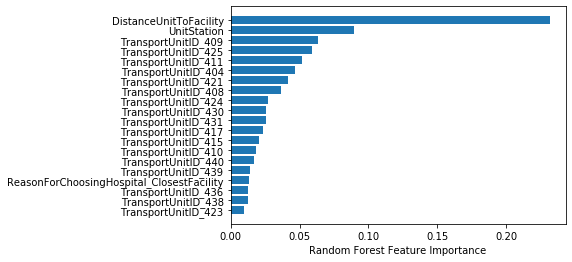

In [137]:
sorted_idx = clfRandom_best.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx[-20:]], clfRandom_best.feature_importances_[sorted_idx[-20:]])
plt.xlabel("Random Forest Feature Importance")

In [138]:
# pd.Series(X.columns).value_counts()

In [170]:
# from lightgbm import LGBMClassifier

In [171]:
# lgb = LGBMClassifier(random_state=12)
# %time lgb.fit(X_train, y_train)
# y_train_pred= lgb.predict(X_train)
# y_test_pred= lgb.predict(X_test)

Wall time: 27.5 s


Text(0.5, 0, 'Random Forest Feature Importance')

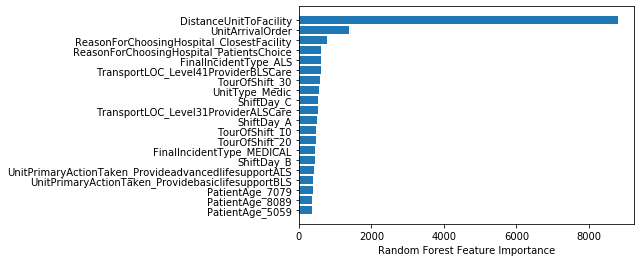

In [172]:
# sorted_idx = lgb.feature_importances_.argsort()
# plt.barh(X.columns[sorted_idx[-20:]], lgb.feature_importances_[sorted_idx[-20:]])
# plt.xlabel("Random Forest Feature Importance")

In [157]:
# accuracy_score(y_train, y_train_pred), f1_score(y_train, y_train_pred, average='weighted')

In [158]:
# accuracy_score(y_test,y_test_pred), f1_score(y_test, y_test_pred, average='weighted')

In [242]:
# prob = lgb.predict_proba(X)
# pred = lgb.predict(X)

In [140]:
import numpy as np


In [141]:
incidentpatientunitsfacilitiesmerge["model_probability"] = np.max(prob, axis=1)
incidentpatientunitsfacilitiesmerge["model_prediction"] = pred

In [151]:
incidentpatientunitsfacilitiesmerge["mismatch_exists"] = incidentpatientunitsfacilitiesmerge.TransportHospitalName != incidentpatientunitsfacilitiesmerge.model_prediction

In [152]:
incidentpatientunitsfacilitiesmerge["mismatch_exists"].value_counts()

False    95126
True     32498
Name: mismatch_exists, dtype: int64

In [153]:
incidentpatientunitsfacilitiesmerge.to_excel("dataset/model_predictions.xlsx", index=False)

## Analyze Data

In [154]:
import pandas as pd

In [155]:
incidentpatientunitsfacilitiesmerge = pd.read_excel("dataset/model_predictions.xlsx")
incidentpatientunitsfacilitiesmerge.shape

(127624, 19)

In [156]:
def analyze_feature(df:pd.DataFrame, feature:str, confidence_threshold: float=0.9, min_records:int=10):
    t1 = df[feature].value_counts()
    mismatch = df[df.TransportHospitalName != df.model_prediction]
    t2 = mismatch[mismatch.model_probability >= confidence_threshold][feature].value_counts()
    t3 = pd.concat([t1, t2], axis=1).reset_index()
    t3.columns = [feature, "total_count", "mismatch_count"]
    t3 = t3[t3.total_count>= min_records]
    t3["percentage_of_mismatch"] = (t3.mismatch_count / t3.total_count )*100
    return t3.sort_values("percentage_of_mismatch", ascending=False)

In [157]:
incidentpatientunitsfacilitiesmerge.columns

Index(['TransportUnitID', 'TransportLOC', 'TransportHospitalName',
       'ReasonForChoosingHospital', 'PatientAge', 'PrimaryImpression',
       'PatientDisposition', 'UnitPrimaryActionTaken', 'UnitStation',
       'UnitType', 'UnitArrivalOrder', 'ShiftDay', 'TourOfShift',
       'IncidentFirstDue', 'FinalIncidentType', 'DistanceUnitToFacility',
       'model_probability', 'model_prediction', 'mismatch_exists'],
      dtype='object')

In [163]:
for feature in ['TransportUnitID', 'TransportLOC',
           'ReasonForChoosingHospital', 'PatientAge', 'PrimaryImpression',
           'PatientDisposition',  'UnitPrimaryActionTaken',
           'UnitStation', 'UnitType', 'UnitArrivalOrder', 'ShiftDay',
           'TourOfShift', 'IncidentFirstDue', 'FinalIncidentType']:

        subset_dataset = analyze_feature(incidentpatientunitsfacilitiesmerge, 
                                                        feature,
                                                        0.4, 100)
        
        if max(subset_dataset['percentage_of_mismatch']) > 10:
            print("Interesting features to investigate", feature)

    


Interesting features to investigate TransportUnitID
Interesting features to investigate TransportLOC
Interesting features to investigate ReasonForChoosingHospital
Interesting features to investigate PatientAge
Interesting features to investigate PrimaryImpression
Interesting features to investigate PatientDisposition
Interesting features to investigate UnitPrimaryActionTaken
Interesting features to investigate UnitStation
Interesting features to investigate UnitType
Interesting features to investigate UnitArrivalOrder
Interesting features to investigate ShiftDay
Interesting features to investigate TourOfShift
Interesting features to investigate IncidentFirstDue
Interesting features to investigate FinalIncidentType


In [160]:
analyze_feature(incidentpatientunitsfacilitiesmerge, 
                                                    "ReasonForChoosingHospital",
                                                    0.5, 100)

,ReasonForChoosingHospital,total_count,mismatch_count,percentage_of_mismatch
23,"Patient's Choice,Patient's Physician's Choice",136,19.0,13.970588
16,Diversion,230,30.0,13.043478
9,"Patient's Choice,Family Choice",1011,101.0,9.990109
19,Other,169,11.0,6.508876
2,Family Choice,7253,397.0,5.473597
8,Patient's Physician's Choice,1169,57.0,4.875962
10,"Family Choice,Patient's Choice",557,27.0,4.847397
3,"Specialty Center (Trauma, STEMI, Stroke)",5687,232.0,4.079480
7,Protocol,1381,53.0,3.837799
24,"Specialty Center (Trauma, STEMI, Stroke),Famil...",132,5.0,3.787879


In [168]:
analyze_feature(incidentpatientunitsfacilitiesmerge, "DistanceUnitToFacility", 0.6)

,DistanceUnitToFacility,total_count,mismatch_count,percentage_of_mismatch
123,6.397667,149,131.0,87.919463
2,0.183933,83,62.0,74.698795
303,10.705726,97,66.0,68.041237
11,1.501168,83,54.0,65.060241
49,3.738742,141,90.0,63.829787
...,...,...,...,...
711,6838.861260,119,NaN,NaN
712,6839.748151,50,NaN,NaN
713,6841.737795,276,NaN,NaN
714,6841.943243,40,NaN,NaN


In [171]:
analyze_feature(incidentpatientunitsfacilitiesmerge[incidentpatientunitsfacilitiesmerge.TransportUnitID== 425], 
                                                    "PrimaryImpression",
                                                    0.7, 100)

,PrimaryImpression,total_count,mismatch_count,percentage_of_mismatch
20,"Injury - Wrist, Hand, or Fingers (S69.9)",252,4.0,1.587302
27,Neuro - Headache (R51),209,3.0,1.435407
34,Abuse of Narcotic / Opioid / Heroin (Overdose)...,179,2.0,1.117318
2,Abuse of Alcohol (ETOH) - Intoxication (F10.92),592,5.0,0.844595
5,Syncope - Syncopal/Fainting Episode (or Near) ...,532,4.0,0.751880
16,GI/GU - Nausea (With Vomiting) (R11.2),280,2.0,0.714286
14,Pain - Extremity (Non-traumatic) (M79.609),295,2.0,0.677966
41,Behavioral - Strange Behavior (R46.2),151,1.0,0.662252
38,Injury - Ankle (S99.91),166,1.0,0.602410
6,Injury - Head without L.O.C. (S06.0X0A),530,3.0,0.566038


In [259]:
analyze_feature(incidentpatientunitsfacilitiesmerge[incidentpatientunitsfacilitiesmerge.ReasonForChoosingHospital== "Patient's Choice,Family Choice"], 
                                                    "PrimaryImpression",
                                                    0.9, 100)

,PrimaryImpression,total_count,mismatch_count,percentage_of_mismatch
0,Weakness (R53.1),178,NaN,NaN
1,Respiratory - Acute Distress/ Breathing Diffic...,173,NaN,NaN
2,Syncope - Syncopal/Fainting Episode (or Near) ...,109,NaN,NaN


In [260]:
analyze_feature(incidentpatientunitsfacilitiesmerge, "TransportUnitID")

,TransportUnitID,total_count,mismatch_count,percentage_of_mismatch
0,408,17518,NaN,NaN
1,425,16747,NaN,NaN
2,409,15771,NaN,NaN
3,411,15619,NaN,NaN
4,422,11399,NaN,NaN
5,410,10875,NaN,NaN
6,430,10184,NaN,NaN
7,421,8892,NaN,NaN
8,426,8675,NaN,NaN
9,405,8653,NaN,NaN


In [261]:
analyze_feature(incidentpatientunitsfacilitiesmerge[incidentpatientunitsfacilitiesmerge.TransportUnitID== 415], 
                                                    "PrimaryImpression",
                                                    0.9, 100)

,PrimaryImpression,total_count,mismatch_count,percentage_of_mismatch
0,Pain - Not Elsewhere Mentioned Sudden Onset (G...,375,NaN,NaN
1,Respiratory - Acute Distress/ Breathing Diffic...,359,NaN,NaN
2,Syncope - Syncopal/Fainting Episode (or Near) ...,331,NaN,NaN
3,Weakness (R53.1),304,NaN,NaN
4,Neuro - Altered Mental Status / Level of Consc...,269,NaN,NaN
5,Neuro - Seizure (G40.909),266,NaN,NaN
6,Injury - Head without L.O.C. (S06.0X0A),257,NaN,NaN
7,Injury - Neck (S19.9),219,NaN,NaN
8,Abuse of Alcohol (ETOH) - Intoxication (F10.92),203,NaN,NaN
9,CV - Chest Pain - Angina (I20.0),183,NaN,NaN


In [262]:
analyze_feature(incidentpatientunitsfacilitiesmerge[incidentpatientunitsfacilitiesmerge.TransportUnitID== "415"], 
                                                    "PrimaryImpression",
                                                    0.9, 100)

D:\Softwares\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,PrimaryImpression,total_count,mismatch_count,percentage_of_mismatch


In [15]:
incidentpatientunitsfacilitiesmerge

,TransportUnitID,TransportLOC,TransportHospitalCode,ReasonForChoosingHospital,PatientAge,PrimaryImpression,PatientDisposition,TransportUnitLOC,UnitPrimaryActionTaken,UnitStation,UnitType,UnitArrivalOrder,ShiftDay,TourOfShift,IncidentFirstDue,FinalIncidentType,model_probability,model_prediction,Mismatch
0,401,Level 3: 1 Provider (ALS Care),3,"Patient's Choice,Closest Facility",80 - 89,GI/GU - Nausea (With Vomiting) (R11.2),Treated & Transported,ALS-Paramedic,Provide manpower,1,Engine,2,B,1.0,1,ALS,1.000000,11,True
1,401,Level 3: 1 Provider (ALS Care),3,"Patient's Choice,Closest Facility",80 - 89,GI/GU - Nausea (With Vomiting) (R11.2),Treated & Transported,ALS-Paramedic,Provide advanced life support (ALS),1,Medic,1,B,1.0,1,ALS,1.000000,11,True
2,401,Level 4: 1 Provider (BLS Care),3,Patient's Choice,80 - 89,EENT - Eye Pain (Non-traumatic) (H57.10),Treated & Transported,ALS-Paramedic,Provide advanced life support (ALS),1,Medic,1,A,3.0,1,BLS,0.613191,3,False
3,401,Level 4: 1 Provider (BLS Care),16,Closest Facility,40 - 49,Injury - Foot (S99.92),Treated & Transported,ALS-Paramedic,Provide manpower,1,Engine,1,B,2.0,1,BLS,0.691172,16,False
4,401,Level 4: 1 Provider (BLS Care),16,Closest Facility,40 - 49,Injury - Foot (S99.92),Treated & Transported,ALS-Paramedic,Provide advanced life support (ALS),1,Medic,2,B,2.0,1,BLS,0.690932,16,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283445,429,Level 4: 1 Provider (BLS Care),16,"Closest Facility,Family Choice",80 - 89,Injury - Lower leg (S89.9),Treated & Transported,ALS-Paramedic,"Emergency medical services, other",28,Engine,1,C,2.0,1,MEDICAL,0.917983,16,False
283446,429,Level 4: 1 Provider (BLS Care),16,"Closest Facility,Family Choice",80 - 89,Injury - Lower leg (S89.9),Treated & Transported,ALS-Paramedic,Provide basic life support (BLS),29,Medic,2,C,2.0,1,MEDICAL,1.000000,3,True
283447,429,Level 2: 2 Providers (ALS Care),16,Closest Facility,2021-10-19 00:00:00,Neuro - Altered Mental Status / Level of Consc...,Treated & Transported,ALS-Paramedic,Provide advanced life support (ALS),1,Engine,1,A,1.0,1,MEDICAL,0.914441,16,False
283448,429,Level 2: 2 Providers (ALS Care),16,Closest Facility,2021-10-19 00:00:00,Neuro - Altered Mental Status / Level of Consc...,Treated & Transported,ALS-Paramedic,Cancelled en route,13,Engine,0,A,1.0,1,MEDICAL,0.999853,16,False


In [371]:
analyze_feature(incidentpatientunitsfacilitiesmerge[(incidentpatientunitsfacilitiesmerge.TransportUnitID == "415")],
               "TransportHospitalCode")

,original,mismatch,percentage_of_mismatch
36,34,22.0,0.647059
3,15,7.0,0.466667
95,1531,435.0,0.284128
16,453,122.0,0.269316
11,4921,1250.0,0.254013
59,25,5.0,0.200000


In [360]:
incidentpatientunitsfacilitiesmerge.head(1)

,TransportUnitID,TransportLOC,TransportHospitalCode,ReasonForChoosingHospital,PatientAge,PrimaryImpression,PatientDisposition,TransportUnitLOC,UnitPrimaryActionTaken,UnitStation,UnitType,UnitArrivalOrder,ShiftDay,TourOfShift,IncidentFirstDue,FinalIncidentType,model_probability,model_prediction
0,401,Level 3: 1 Provider (ALS Care),3,"Patient's Choice,Closest Facility",80 - 89,GI/GU - Nausea (With Vomiting) (R11.2),Treated & Transported,ALS-Paramedic,Provide manpower,1,Engine,2,B,1.0,1.0,ALS,1.0,11


In [12]:
analyze_feature(incidentpatientunitsfacilitiesmerge[incidentpatientunitsfacilitiesmerge.TransportUnitID== "415"], 
                                                    "PrimaryImpression",
                                                    0.9, 100)

D:\Softwares\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,PrimaryImpression,total_count,mismatch_count,percentage_of_mismatch


In [13]:
analyze_feature(incidentpatientunitsfacilitiesmerge[incidentpatientunitsfacilitiesmerge.TransportUnitID== "405"], 
                                                    "PrimaryImpression",
                                                    0.5)

D:\Softwares\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,PrimaryImpression,total_count,mismatch_count,percentage_of_mismatch
